In [1]:
from __future__ import print_function
import logging
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import torch.optim as optim
import os
from os import listdir
import random
import copy
from torch.utils.data import DataLoader
from skimage import measure #supports video also
import pickle
from scipy.spatial import distance
import time
import platform

from utils.Network import Network
from utils.Analyser import Analyser
from utils.io import save_network, save, load, figure_save, load_network, make_folder_results, imshow
from utils.format import hex_str2bool
from utils.WaveDataset import Create_Datasets

In [2]:
logging.basicConfig(format='%(message)s',level=logging.INFO)
channels=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

nr_net = 0 

version = nr_net + 10
num_input_frames = 5
num_output_frames = 10
network_type = "7_kernel_3LSTM"

if 'Darwin' in platform.system():
    data_dir = './'
else:
    data_dir = '/disk/scratch/s1680171/wave_propagation/'

if not os.path.isdir("./Results"):
    os.mkdir("./Results")
results_dir = "./Results/" + network_type + "_v%03d/" % version

if not os.path.isdir(results_dir):
    make_folder_results(results_dir)
    
# Data
filename_data = results_dir + "all_data.pickle"
if os.path.isfile(filename_data):
    logging.info('Loading datasets')
    all_data = load(filename_data)
    train_dataset = all_data["Training data"]
    val_dataset = all_data["Validation data"]
    test_dataset = all_data["Testing data"]
else:
    logging.info('Creating new datasets')
    test_dataset, val_dataset, train_dataset = Create_Datasets(
         data_dir+"Video_Data/", transformVar, test_fraction=0.15, validation_fraction=0.15, check_bad_data=False, channels=channels)
    all_data = {"Training data": train_dataset, "Validation data": val_dataset, "Testing data": test_dataset}
    save(all_data, filename_data)
    
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=12)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=12)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=12)

Loading datasets


In [3]:
model = Network(device, channels)
load_network(model, device, "Results/Simulation_Result_7_kernel_3LSTM_v010/7_kernel_3LSTM_model_v010.pt")

Warning: model and dictionary mismatch

In [4]:
def initial_input(model, image_series, starting_point, num_input_frames, channels, device, training):
    n = 0
    input_frames = image_series[:, (starting_point + n) * channels:(starting_point + n + num_input_frames) * channels, :, :].to(device)
    output_frames = model(input_frames, training=training)
    index = starting_point + n + num_input_frames
    target = image_series[:, index * channels:(index + 1) * channels, :, :].to(device)
    return output_frames, target

def new_input(model, image_series, starting_point, num_input_frames, num_output_frames, output_frames, target, channels, device, training):
    output_frames = torch.cat((output_frames, model(output_frames[:, -num_input_frames * channels:, :, :].clone(), mode="new_input", training=training)), dim=1)
    index = starting_point + num_output_frames + num_input_frames
    target = torch.cat((target, image_series[:, index * channels:(index + 1) * channels, :, :].to(device)), dim=1)
    return output_frames, target

def consequent_propagation(model, image_series, starting_point, n, output_frames, target, channels, device, training):
    output_frames = torch.cat((output_frames, model(torch.Tensor([0]), mode="internal", training=training)), dim=1)
    index = starting_point + n + num_input_frames
    target = torch.cat((target, image_series[:, index*channels:(index + 1) * channels, :, :].to(device)), dim=1)
    return output_frames, target

def plot_predictions(output_frames, target, channels):
    predicted = output_frames[i, -channels:, :, :].cpu().detach()
    des_target = target[i, -channels:, :, :].cpu().detach()
    fig = plt.figure()
    pred = fig.add_subplot(1, 2, 1)
    imshow(predicted, title="Predicted smoothened %02d" % n, smoothen=True, obj=pred)
    tar = fig.add_subplot(1, 2, 2)
    imshow(des_target, title="Target %02d" % n, obj=tar)
    plt.show()


In [5]:
len(val_dataloader)

31

In [42]:
len(random_starting_points)

10

In [109]:
debug=True
plot = True
training = False
model.eval()
overall_loss = 0
for batch_num, batch in enumerate(val_dataloader):
    print('batch ', batch_num)
    random_starting_points = random.sample(range(100 - num_input_frames - (2 * num_output_frames) - 1), 10)
    image_series = batch["image"]
    batch_loss = 0
    for i, starting_point in enumerate(random_starting_points):
        print('\ni=%d starting_point=%d' % (i,starting_point))
        model.reset_hidden(batch_size=image_series.size()[0], training=False)
        for n in range(2 * num_output_frames):
            if n == 0:
                print('initial_input n=0')
                output_frame, target_frame = initial_input(model, image_series, starting_point, num_input_frames, channels, device, training=training)
            elif n == num_output_frames:
                print('new_input n=%d' %n)
                output_frame, target_frame = reinsert(model, image_series, starting_point, num_input_frames, num_output_frames, output_frame, target_frame, channels, device, training=training)
            else:
                print('consequent_propagation n=%d'% n)
                output_frame, target_frame = propagate(model, image_series, starting_point, num_input_frames, n, output_frame, target_frame, channels, device, training=training)
            if plot and (i == 0) and (n==0):
                plot_predictions(output_frame, target, channels)
        batch_loss += F.mse_loss(output_frame, target).item()
    overall_loss += batch_loss / (i + 1)
    if debug: break
val_loss = overall_loss / (batch_num + 1)
# return val_loss

KeyboardInterrupt: 

In [12]:
output_frames.size()

torch.Size([16, 20, 128, 128])

In [13]:
target.size()

torch.Size([16, 20, 128, 128])

In [14]:
predicted = output_frames[i, -channels:, :, :].cpu().detach()

In [15]:
predicted.size()

torch.Size([1, 128, 128])

In [22]:
batch['image'].size()

torch.Size([16, 100, 128, 128])

In [26]:
image_series[0:5,:,:].size()

torch.Size([5, 100, 128, 128])

In [24]:
starting_point

46

In [30]:
num_input_frames

5

In [107]:
# def initial_input(model, image_series, starting_point, num_input_frames, channels, device, training):
n = 0
input_frames = image_series[:, (starting_point + n) * channels:(starting_point + n + num_input_frames) * channels, :, :].to(device)
output_frame = model(input_frames, training=training)
index = starting_point + n + num_input_frames
target_frame = image_series[:, index * channels:(index + 1) * channels, :, :].to(device)

AttributeError: 'Network' object has no attribute 'LSTM_initial_input'

In [108]:
input_frames.size()

torch.Size([16, 5, 128, 128])

In [96]:
image_series.size()

torch.Size([16, 100, 128, 128])

In [98]:
output_frame.size()

torch.Size([16, 1, 128, 128])

In [99]:
target.size()

torch.Size([16, 1, 128, 128])

In [100]:
output_frame = torch.cat((output_frame, model(output_frame[:, -num_input_frames * channels:, :, :].clone(), mode="reinserting", training=training)), dim=1)
index = starting_point + num_output_frames + num_input_frames
target_frame = torch.cat((target_frame, image_series[:, index * channels:(index + 1) * channels, :, :].to(device)), dim=1)

In [101]:
output_frame.size()

torch.Size([16, 2, 128, 128])

In [102]:
target_frame.size()

torch.Size([16, 2, 128, 128])

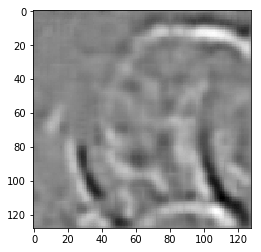

In [106]:
plt.imshow(output_frame[1,1,:,:],cmap='gray')

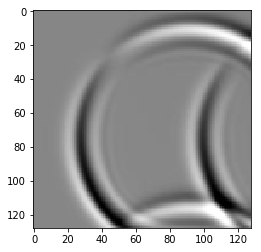

In [92]:
plt.imshow(target_frame[1,0,:,:],cmap='gray')

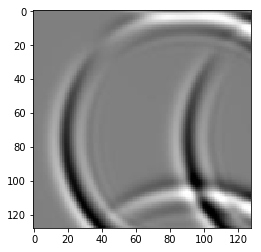

In [93]:
plt.imshow(target_frame[1,1,:,:],cmap='gray')